<a href="https://colab.research.google.com/github/PatrickRuan/DL-CVMarathon/blob/master/homework/Day022_Captcha_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [ ]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
from google.colab import drive
drive.mount('/content/gdrive')
#檢查GPU
!nvidia-smi
#安裝產生驗證碼的套件

## 記得先 pip install captcha

In [2]:
!pip install captcha

     |████████████████████████████████| 102kB 5.1MB/s 


## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'RIY2')

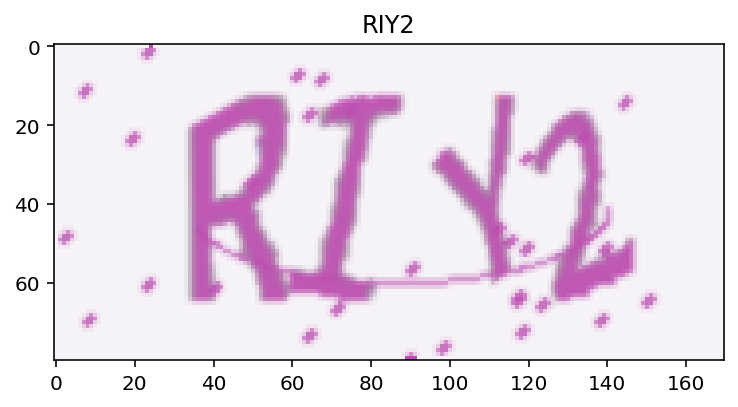

In [8]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文大寫字母
characters = string.digits + string.ascii_uppercase
print(characters) 
#0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給 **Blank**
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [9]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [18]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

x = Conv2D(32,(3,3), padding ='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32,(3,3), padding ='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2), strides=(1,1))(x)
x = Conv2D(64,(3,3), padding ='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(128,(3,3), padding ='same', activation = 'relu')(x)
x = BatchNormalization()(x)


##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()
##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x) # Flatten(?)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)

##包裝用來預測的model
base_model = Model(inputs=input_tensor, outputs=x)

##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

In [19]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 80, 170, 32)  896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 80, 170, 32)  128         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 80, 170, 32)  9248        batch_normalization_14[0][0]     
_______________________________________________________________________________________

In [22]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[27 26 35 33]]
CNN輸出寬度:  [84.]
字串長度(可浮動):  [4.]


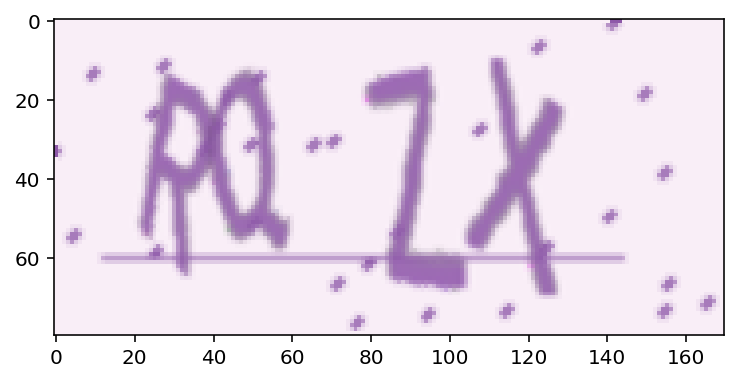

In [27]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [29]:
model.fit_generator(gen(32), steps_per_epoch=50, epochs=60) #steps_per_epoch=300

Epoch 1/60
50/50 [==============================] - 7s 149ms/step - loss: 15.9076
Epoch 2/60
50/50 [==============================] - 7s 148ms/step - loss: 15.8734
Epoch 3/60
50/50 [==============================] - 7s 148ms/step - loss: 15.6887
Epoch 4/60
50/50 [==============================] - 7s 149ms/step - loss: 15.5899
Epoch 5/60
50/50 [==============================] - 7s 149ms/step - loss: 15.4327
Epoch 6/60
50/50 [==============================] - 7s 147ms/step - loss: 15.4517
Epoch 7/60
50/50 [==============================] - 7s 148ms/step - loss: 15.3871
Epoch 8/60
50/50 [==============================] - 7s 148ms/step - loss: 15.3575
Epoch 9/60
50/50 [==============================] - 7s 148ms/step - loss: 15.3334
Epoch 10/60
50/50 [==============================] - 7s 150ms/step - loss: 15.2098
Epoch 11/60
50/50 [==============================] - 7s 150ms/step - loss: 15.2439
Epoch 12/60
50/50 [==============================] - 7s 149ms/step - loss: 15.2681
Epoch 13/60
5

## 預測

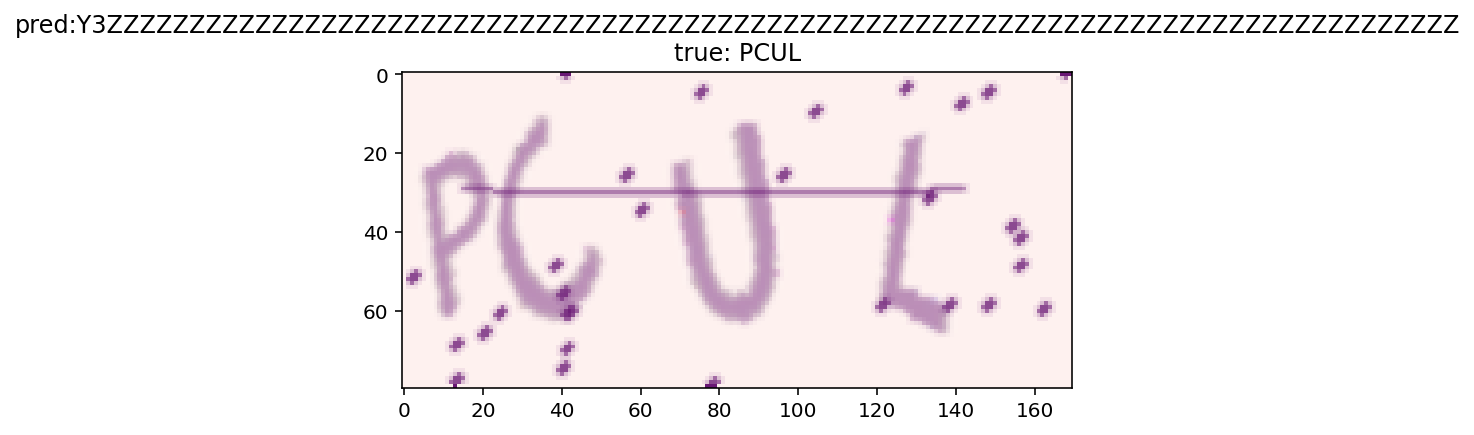

In [37]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [ ]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

## 額外參考：加入RNN的神經網路

In [41]:
width

170

In [52]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    print(i)
    x = Convolution2D(32, 3, 3,padding = 'same', activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, padding ='same', activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <1:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    #else:
    #    x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, name='gru1')(x) # init='he_normal',
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
              name='gru1_b')(x) #init='he_normal',
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True,  name='gru2')(gru1_merged) #init='he_normal',
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             name='gru2_b')(gru1_merged) # init='he_normal',
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class,  activation='softmax')(x) #init='he_normal'

base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

0
1
2
3


In [53]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 27, 57, 32)   896         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 27, 57, 32)   128         conv2d_78[0][0]                  
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 9, 19, 32)    9248        batch_normalization_76[0][0]     
______________________________________________________________________________________